# Exploring Classifiers: beyond accuracy

If everything went well, you fully understand the code below:

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline

model_lr = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

print(model_lr)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])


Also, you know how to train this model and how to get its accuracy on a test set:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 

df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], test_size=0.2)
# Train the pipeline
model_lr.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [3]:
y_pred = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.79


We are now going to explore how to go beyond accuracy to analyze and report our results.

## Exercise 1: Recall, Precision, F1-Score

Accuracy is simply the number of correctly classified items divided by the total number of items in a dataset. It is an estimate of $P(\text{correct answer})$ all over the test data.

However, we might want to use a greater granularity to this measurement. Usually, these are per-class measures. For such, we can use:

Recall

$$
R = \frac{\text{\# of correctly found items of a class}}{\text{\# of items of the class in the dataset}}
$$

Precision:

$$
P = \frac{\text{\# of correctly found items of a class}}{\text{\# of items classified as class by the system}}
$$

F1-Score (harmonic mean between $R$ and $P$):

$$
F = \frac{2RP}{R+P}
$$

Optionally, we could use the balanced accuracy, which is the classwise per-class accuracy.

Sklearn implements these measures as:

In [5]:
from sklearn.metrics import recall_score, precision_score, f1_score, balanced_accuracy_score

recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1: {f1:.2f}')
print(f'Balanced accuracy: {bal_acc:.2f}')


Recall: 0.77
Precision: 0.79
F1: 0.77
Balanced accuracy: 0.77


Also, sklearn allows you to print a more complete per-class classification report:

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      comedy       0.81      0.65      0.72       863
       drama       0.78      0.89      0.83      1206

    accuracy                           0.79      2069
   macro avg       0.79      0.77      0.77      2069
weighted avg       0.79      0.79      0.78      2069



Using these results, discuss:

1. What types of errors (in terms of: "the true class is A but the system is saying "B") are more common in our system?

* Drama has less precision, which means it says is drama when it is comedy.

1. Was the simple accuracy score misleading?

* It is not misleading, but leaves out information that can be useful to understand the system.

(That can also have to do with the fact that the classes are unbalanced, we have 50% more drama than comedy)

## Exercise 2: The Confusion Matrix

A common way to report classification errors is the Confusion Matrix. The confusion matrix is a square matrix where element $c_{i,j}$ indicates the number of times an item whose true class is $i$ and the predicted class is $j$.

Using the confusion matrix below, calculate:

1. The probability that, if the system predicts a plot is comedy, it is actually comedy.
1. The probability that, if the system predicts a plot is drama, it is actually drama.

[[ 559  304]
 [ 135 1071]]


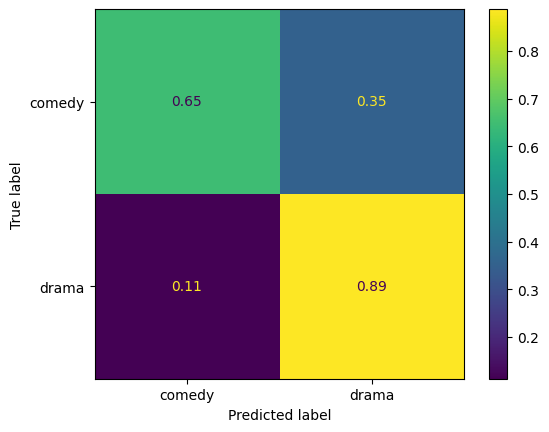

In [12]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred)
print(c)
c = confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(c, display_labels=['comedy', 'drama']).plot()

## Exercise 3: How certain are you?

Simply stating something is from a particular class is useful, but we might want to know how certain the system is about this prediction.

The output of a Logistic Regression is the probability of an item belonging to a class given its characteristics, or:

$$
P(\text{class} | \text{text})
$$

We can directly access this using the `.predict_proba` method in the model. However, as we know, probabilities can saturate close to zero or one, so it is also possible to get the logarithm of the probabilities, using `predict_log_proba`:

In [13]:
my_plot = """
In a small, forgotten town, once-famous clown duo Chuckles and Boomer, along with their pack of hilariously talented dogs, 
decide to bring back the glory days of circuses with a grand show dedicated to their favorite snack: sausages. 
But the town’s greedy mayor has other plans. He wants to build a shopping mall on the circus lot and will stop at nothing to get his way. 
Chuckles and Boomer must pull out all the stops to save their circus and preserve the laughter for generations to come.
"""

y_pred = model_lr.predict([my_plot])
y_prob = model_lr.predict_proba([my_plot])
y_log_prob = model_lr.predict_log_proba([my_plot])
print(f'Predicted genre: {y_pred[0]}')
print(f'Probabilities: {y_prob[0]}')
print(f'Log probabilities: {y_log_prob[0]}')


Predicted genre: comedy
Probabilities: [0.68113344 0.31886656]
Log probabilities: [-0.38399704 -1.14298257]


See, if `y_prob` is close to $0.5$, it means that the system is not exacly "sure" - in the sense that, there is not enough evidence - to attribute a class to an item.

Change your classification system so that, if `y_prob` is between $0.4$ and $0.6$, then the item is classified as "unkown". After that, calculate the classification report again. 

What happened to Recall and Precision, and why?

In what use cases would this difference be useful? In what use cases would this difference be harmful?

In [23]:
# Solve your exercise here

def classify_with_unknown(plot, model):
    probas = model.predict_proba([plot])

    if probas[0][0] >= 0.4 and probas[0][0] <= 0.6:
        return "unknown"
    elif probas[0][0] > 0.6:
        return "comedy"
    else:
        return "drama"

In [28]:
y_pred = list(X_test.apply(lambda x: classify_with_unknown(x, model_lr)))

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      comedy       0.89      0.41      0.56       863
       drama       0.85      0.73      0.78      1206
     unknown       0.00      0.00      0.00         0

    accuracy                           0.59      2069
   macro avg       0.58      0.38      0.45      2069
weighted avg       0.86      0.59      0.69      2069



/home/joaolucasmbc/mambaforge/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joaolucasmbc/mambaforge/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joaolucasmbc/mambaforge/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Our precision went up, which makes sense given that the creation of a "unknown class" eliminates the bulk of the more amibuous texts, making it so the classification on both classes is only made when the probability of the class is high enough.

On the contrary, for the exact same reasons, the recall has gone down.

## Exercise 4: why did you classify it as you did?

Another thing you might be interested in is finding out why a classifier predicted that something belongs to a particular class. In the case of Logistic Regression, we can retrieve the logits generated by a text (that is, the $z$ variable in the Logistic Regression schema). If we calculate the decision function for single words, we are simply retrieving the results of $x_n \beta_n$, where $x_n$ is a TFIDF factor for that word, and $\beta_n$ is the weight given to that word. For example, in the code below, note that changing "comedy" for "sadness" makes the decision function shift signals - and the absolute value of $z$ is more extreme if you find words that are more comedy-like or more drama-like:

In [39]:
import numpy as np

plot = "light"

z = model_lr.decision_function([plot])
print(f'Decision function: {z}')
y = 1/(1 + np.exp(-z))
print(f'After logistic function: {y}')
y_prob = model_lr.predict_proba([plot])
print(f'Predicted probability: {y_prob[0]}')

Decision function: [0.664596]
After logistic function: [0.66029206]
Predicted probability: [0.33970794 0.66029206]


Now, make a function that receives a movie plot and a model as input and returns a dataclass containing the movie genre, the probability it belongs to that genre, and the words (within the plot) that are most prominent towards classifying the movie in that genre.

In [41]:
from dataclasses import dataclass

@dataclass
class MovieClassification:
    genre: str
    probability: float
    top_5_words: list


def classify(model: Pipeline, plot: str) -> MovieClassification:
    y = model.predict([plot])[0]
    y_proba = model.predict_proba([plot])[0][0]

    words = plot.lower().split()
    words = np.array(list(set(words)))

    decision_words = model.decision_function(words)
    sorted_idx = np.argsort(decision_words)

    if y == "comedy":
        best_words = words[sorted_idx[:5]]
    else:
        best_words = words[sorted_idx[-5:]]

    output = MovieClassification(
        y,
        y_proba,
        best_words,
    )
    return output

classify(model_lr, my_plot)

MovieClassification(genre='comedy', probability=np.float64(0.6811334404058551), top_5_words=array(['get', 'all', 'show', 'to', 'out'], dtype='<U11'))

## Exercise 5: adjusting hyperparameters

In Logistic Regression, the coefficients $\beta_n$ are called *parameters*. However, our model has some parameters that govern how parameters are obtained. These are called "hyperparameters". We usually want to tune our hyperparameters, but we often have no idea as to what the hyperparameters should be. 

The technique to tune hyperparameters is called "cross-validation". It works like this.

The trainig set will be further divided into a "train" and a "validation" set. For each combination of hyperparameters, we will train the system in the new "train" set, and evaluate it in the "valitation" set. Then, we will choose the hyperparameter configuration that lead to the best results in the validation set. With that configuration, we train the system in the full training set, and then report the results in the test set.

This is somewhat tricky to program, but scikit learn already implements this idea:


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

df = pd.read_csv(
    'https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv'
)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Plot'],
                                                    df['Genre'],
                                                    test_size=0.2)


model_lr = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                     ('classifier', LogisticRegression())])

param_grid = {
    'vectorizer__min_df': [1, 5, 0.01],
    'vectorizer__max_df': [1.0, 0.9, 0.3],
    'vectorizer__binary': [True, False],
    'classifier__C': [1e-1, 1e0, 1e1],
}

grid_search = GridSearchCV(
    model_lr,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_:.2f}')

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'classifier__C': 10.0, 'vectorizer__binary': True, 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1}
Best cross-validation accuracy: 0.80
              precision    recall  f1-score   support

      comedy       0.82      0.73      0.78       889
       drama       0.81      0.88      0.85      1180

    accuracy                           0.82      2069
   macro avg       0.82      0.81      0.81      2069
weighted avg       0.82      0.82      0.82      2069



Change the code above and add to the grid search so that we can find out:

1. Should we use stop words?
1. Should we use ngrams in the vectorizer (parameter: `ngram_range`), so we would consider the order of words somehow? 
1. Should/can we limit our vocabulary (`max_features`) so that only the a few thousand words are considered?

This test should take some minutes. You may want to test only a few parameters at a time to speed things up a bit.



## Exercise 6: how much data we need?

At this point, you should be comfortable with the idea that a classifier has an *accuracy*. We have studied that accuracies can vary a bit when we reshuffle data, and that changing the data representation or the model can have some impact on the accuracy. Today, we are going to take a look at the dataset.

### An upper bound for classification accuracy

Remember that a classifier calculates $p_j = P(\text{class} = c_j | \text{features})$ for each class $c_j$ and then yiels the label of the class with higher probability. We know that using too few data points can lead to a poor estimation of $p_j$, but let's focus on this ideal scenario in which we have an infinite amount of data and our probability estimators are completely fit.

We could have, for example, $p_0=0.8$ and $p_1=0.2$. In this case, the classifier would indicate that the correct class is $c_0$. However, there is still a $0.2$ probability that the correct class is $c_1$. In other words, this perfectly adjusted classifier, even if perfectly modelling the true distribution of data, is still going to be wrong $20\%$ of the time.

For most features, this upper bound for accuracy exists - even if we don't reach it. This is called a Bayes limit, as it is an upper bound for the accuracy of classifiers based on the posterior probabilities.

### Overfitting and avoiding overfitting

Suppose we have only fitted our classifier with one data item. In this case, the classifier is perfectly adjusted for that one item. Hence, the classification accuracy for that one item is $1.0$. However, its parameters are not meaningful for any other data points. This phenomenon is called "overfitting".

As we increase the size of the training set, the adjustments are made towards representative aspects of the dataset. For larger datasets, the representative aspects are not necessarily representative of each data item. This is similar to an estimation of, for example, a mean value. We can get the mean height for students in our classroom, and this estimate would be more precise as we increase the number of students used for calculating that mean. However, as we increase this number (which is our "training dataset size"), there is a higher probability that the mean is not representative of *each one* of the students in the training set.

As a consequence, the accuracy in the training set tends to decrease as the training dataset increases. But, will it decrease forever? Well, we know that it should go down to the Bayes limit we discussed above, but it doesn't make sense to expect it to go much below it.

Conversely, as the training dataset increases in size, the classification accuracy in the testing set increases, as the model estimate gets closer to "reality".

### How does that happen in practice?

Sklearn can help us viewing a training curve. Let's check and take a look at how to interpret it:

In [93]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

model_lr = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                     ('classifier', LogisticRegression())])

# Define the training sizes
train_sizes, train_scores, test_scores = learning_curve(
    model_lr,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = 2*np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = 2*np.std(test_scores, axis=1)

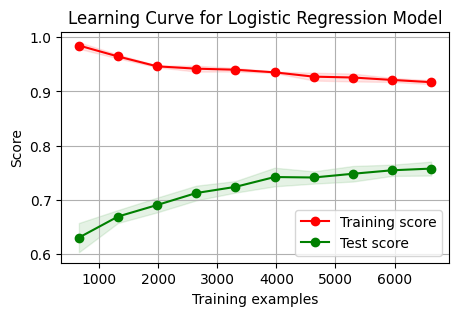

In [94]:
# Plot the learning curve
plt.figure(figsize=(5,3))
plt.title("Learning Curve for Logistic Regression Model")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

# Plot the cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Test score")
# plt.semilogx()
plt.legend(loc="best")
plt.show()

Now, go back to the learning curve plot.

1. Why is there some variance in the scores around each point?
1. Is the curve closer to linear when you uncomment the line `plt.semilogx`?
1. What happens to the test accuracy each time we double the amount of training samples?
1. If we had an infinite amount of data, what would be the accuracy of our system (make a polite guess using the curves!)
1. Could we get 95% accuracy with this model in this dataset, if the dataset was increased?

To learn more about learning curves, refer to:

* [Learning curves: Asymptotic values and rate of convergence (Cortes, ackel, Solla, Vapnik and Denker), Proc. of NIPS 1993](https://papers.nips.cc/paper_files/paper/1993/hash/1aa48fc4880bb0c9b8a3bf979d3b917e-Abstract.html).
* [How Much More Data Do I Need? Estimating Requirements for Downstream Tasks (Mahmood et al.), Proc. of CVPR 2022](https://arxiv.org/pdf/2207.01725)


## Exercise 7: Other Machine Learning Algorithms and Ensembles

If you have taken other Machine Learning courses, or if you have studied Machine Learning in other contexts, you might be aware that there are many algorithms that are able to learn from data. Each of these algorithms stems from a different rationale.

We can run all tests above with different model pipeline configurations, which could be important. I will leave this laborious task as an optional exercise, because it consists of changing one or two lines in each block and then running everything again (at this point, we don't want to show that one strategy is necessarily "better" than another).

Instead, I want to discuss ensembles. The idea of an ensemble is to have many classifiers operating in parallel, and then combining their results. The rationale for this is that, supposably, if one model is "wrong", there is a chance that the other models are "right", so the combined model would be correct more times (on average).

There are many strategies to "combine results". The simplest one is to have each classifier to classify an item, and then use simple voting to find the final classification of that item. It is also possible to use a (possible weighted) mean of the predicted probabilities for each model. Also, it is possible to use the outputs of the classifiers as a large "feature vector" and then use another classifier (a so-called meta-classifier) to make a final decision.

Below, there is an example code showing how to combine many classifiers into a voting ensemble.

1. Add at least two other classifiers to the ensemble. Read sklearn's documentation for such.
1. Using a bar plot (see code below), compare the accuracy and the f1-score of the ensemble and of each isolated classifier

In [8]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

classifier = VotingClassifier([('lr', LogisticRegression()),
                               ('rf', RandomForestClassifier()),
                               ('nb', BernoulliNB())])

model_ensemble = Pipeline([('vectorizer',
                      TfidfVectorizer(
                          stop_words='english',
                          binary=True,
                      )), ('classifier', classifier)])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 

df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/main/wiki_movie_plots_drama_comedy.csv')
print('Data loaded. Training model...')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], test_size=0.2)
# Train the pipeline
model_ensemble.fit(X_train, y_train)


Data loaded. Training model...


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(binary=True, stop_words='english')),
                ('classifier',
                 VotingClassifier(estimators=[('lr', LogisticRegression()),
                                              ('rf', RandomForestClassifier()),
                                              ('nb', BernoulliNB())]))])

In [10]:
y_pred = model_ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.78


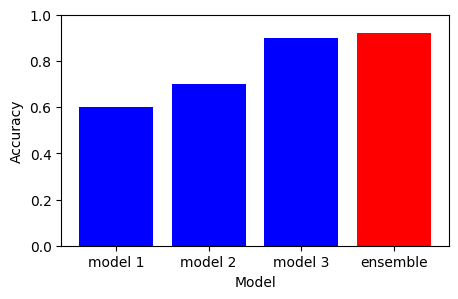

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
# - Sort bars by accuracy
# - Use a different color for the model we want to highlight (possibly our proposal, or, in this case, the ensemble)
plt.bar(['model 1', 'model 2', 'model 3', 'ensemble'], [0.6, 0.7, 0.9, 0.92], color=['blue', 'blue', 'blue', 'red'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Model')
plt.show()